<a href="https://colab.research.google.com/github/Leandro2402-bit/TAM/blob/main/6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


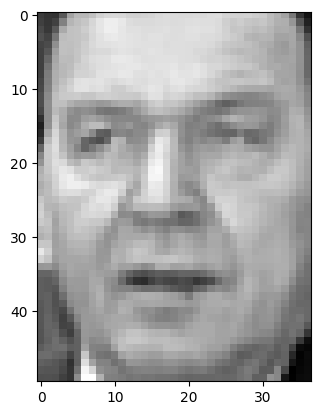

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [4]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [5]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.43286065070595453)

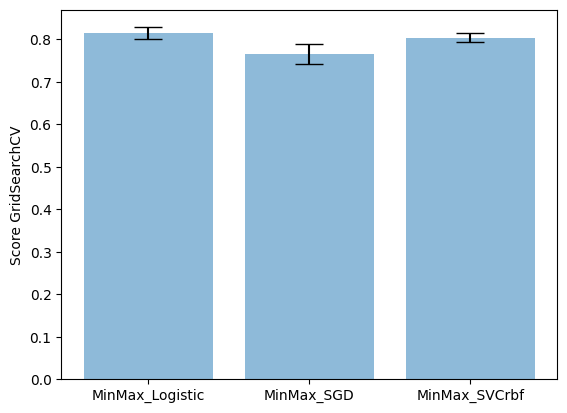

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.765 0.804]
 [0.014 0.023 0.011]]


In [6]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


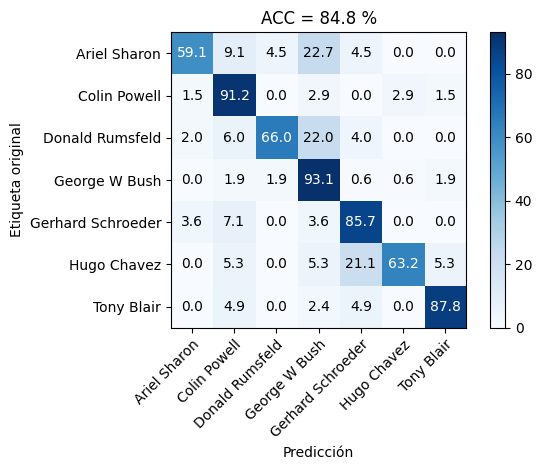

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


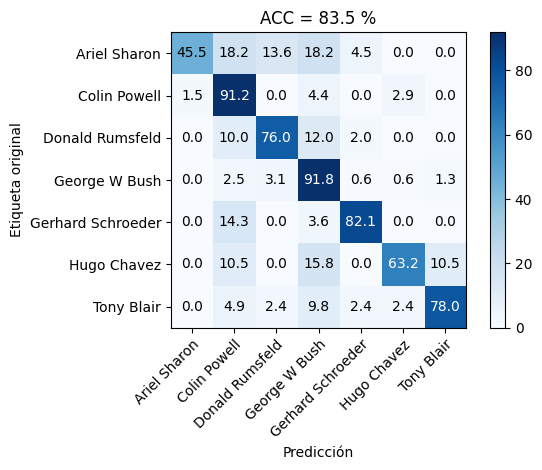

                   precision    recall  f1-score   support

     Ariel Sharon       0.91      0.45      0.61        22
     Colin Powell       0.75      0.91      0.82        68
  Donald Rumsfeld       0.81      0.76      0.78        50
    George W Bush       0.87      0.92      0.90       159
Gerhard Schroeder       0.85      0.82      0.84        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.89      0.78      0.83        41

         accuracy                           0.83       387
        macro avg       0.83      0.75      0.78       387
     weighted avg       0.84      0.83      0.83       387

Evaluando modelo MinMax_SVCrbf (3/3)


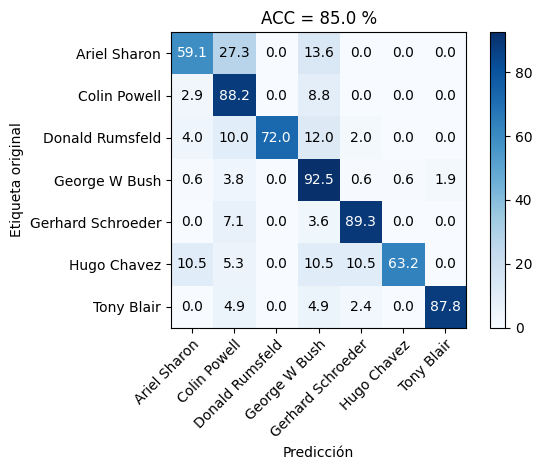

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [7]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


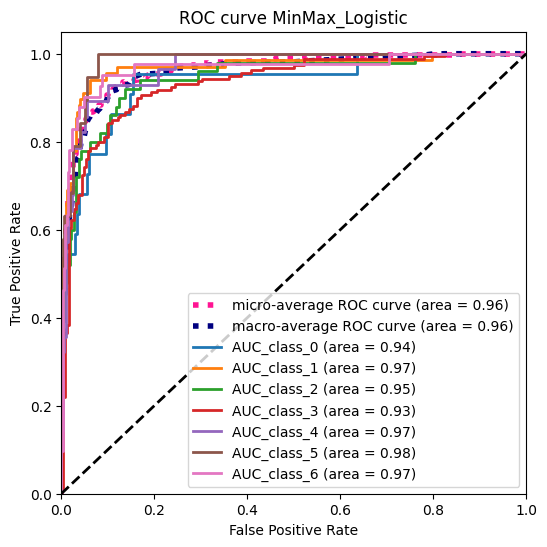

Evaluando modelo MinMax_SGD (2/3)


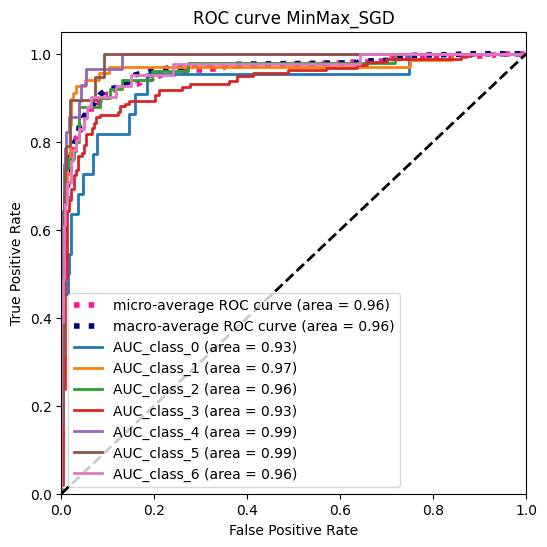

Evaluando modelo MinMax_SVCrbf (3/3)


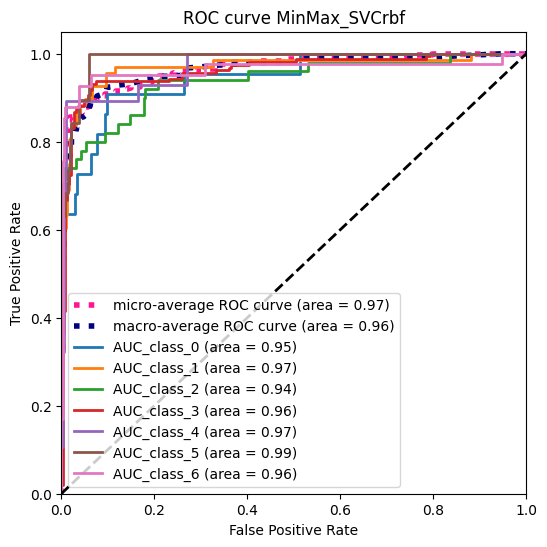

In [8]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


**EJERCICIO 1:**

En este ejercicio exploraremos 8 clasificadores importantes de scikit-learn, analizando:
- Su modelo matemático subyacente.
- El problema de optimización que resuelven.
- Implementación práctica con ejemplos.


## Índice:
1. Naive Bayes Gaussiano
2. SGD Classifier
3. Logistic Regression
4. Linear Discriminant Analysis
5. K-Nearest Neighbors
6. Linear SVC
7. Support Vector Classifier (SVC)
8. Random Forest Classifier

## 1. Naive Bayes Gaussiano

### Modelo Matemático:
El clasificador Naive Bayes se basa en el **Teorema de Bayes** con la asunción "naive" de independencia condicional entre características.

**Fórmula principal:**
```
P(y|x) = P(x|y) × P(y) / P(x)
```

Para características continuas con distribución gaussiana:
```
P(xi|y) = (1/√(2πσy²)) × exp(-(xi-μy)²/(2σy²))
```

### Problema de Optimización:
**No hay optimización explícita**. No hay optimización explícita. Los parámetros se estiman directamente mediante estimación de máxima verosimilitud:
- μy: Media de cada característica por clase
- σy²: Varianza de cada característica por clase  
- P(y): Frecuencia relativa de cada clase (prior)

### Ventajas ✅
- Muy rápido para entrenar y predecir
- Funciona bien con pocos datos
- No es sensible a características irrelevantes

### Desventajas ❌
- Asume independencia entre características (raramente cierto)
- Puede tener mal rendimiento si la asunción gaussiana es incorrecta
"""

# 2. SGD Classifier (Stochastic Gradient Descent)

## Modelo Matemático
El SGD Classifier es un **clasificador lineal** que utiliza descenso de gradiente estocástico para encontrar el hiperplano óptimo de separación.

**Función de decisión:**
```
f(x) = w·x + b
```

**Predicción:**
```
ŷ = sign(f(x))
```

Donde **w** es el vector de pesos y **b** es el sesgo (bias).

## Problema de Optimización
**Objetivo:** Minimizar la función de pérdida usando descenso de gradiente estocástico.

**Función de costo general:**
```
J(w,b) = (1/n) Σ L(yi, f(xi)) + α·R(w)
```

Donde:
- **L()** es la función de pérdida (hinge, log, squared_hinge, etc.)
- **R(w)** es el término de regularización (L1, L2, o Elastic Net)
- **α** es el parámetro de regularización

**Actualización de parámetros:**
```
w := w - η·∇w J(w,b)
b := b - η·∇b J(w,b)
```

## Ventajas ✅
* Muy eficiente para datasets grandes (escalabilidad lineal)
* Bajo consumo de memoria
* Soporte para aprendizaje en línea (online learning)
* Múltiples funciones de pérdida disponibles
* Rápida convergencia en la mayoría de casos

## Desventajas ❌
* Sensible al escalado de características
* Requiere ajuste de hiperparámetros (learning rate, regularización)
* Puede ser inestable con learning rates altos
* Necesita más épocas para convergencia completa comparado con métodos batch

# 3. Logistic Regression

## Modelo Matemático
La Regresión Logística utiliza la **función sigmoide** para mapear cualquier valor real a un valor entre 0 y 1, representando probabilidades.

**Función sigmoide:**
```
σ(z) = 1 / (1 + e^(-z))
```

**Función de decisión:**
```
z = w·x + b
```

**Probabilidad de predicción:**
```
P(y=1|x) = σ(w·x + b) = 1 / (1 + e^(-(w·x + b)))
P(y=0|x) = 1 - P(y=1|x)
```

**Predicción final:**
```
ŷ = 1 if P(y=1|x) ≥ 0.5, else 0
```

## Problema de Optimización
**Objetivo:** Maximizar la verosimilitud (equivalente a minimizar la log-verosimilitud negativa).

**Función de costo (Cross-Entropy Loss):**
```
J(w,b) = -1/n Σ[yi·log(ŷi) + (1-yi)·log(1-ŷi)] + λ·R(w)
```

**Gradiente:**
```
∇w J = 1/n X^T(ŷ - y) + λ·∇w R(w)
∇b J = 1/n Σ(ŷi - yi)
```

Se resuelve usando métodos iterativos como **Newton-Raphson** o **LBFGS**.

## Ventajas ✅
* Proporciona probabilidades de predicción interpretables
* No requiere escalado de características (aunque puede mejorar convergencia)
* Menos sensible a outliers que modelos lineales con pérdida cuadrática
* Convergencia garantizada para datos linealmente separables
* Implementación eficiente y estable

## Desventajas ❌
* Asume relación lineal entre características y log-odds
* Sensible a características altamente correlacionadas
* Puede sufrir overfitting con muchas características
* Requiere grandes muestras para parámetros estables

# 4. Linear Discriminant Analysis (LDA)

## Modelo Matemático
LDA es un clasificador **generativo** que modela la distribución de características para cada clase y utiliza el **Teorema de Bayes** para la clasificación. Asume que las clases siguen distribuciones gaussianas con **matriz de covarianza compartida**.

**Distribución de cada clase:**
```
P(x|y=k) ~ N(μk, Σ)
```

**Función discriminante:**
```
δk(x) = x^T Σ^(-1) μk - (1/2) μk^T Σ^(-1) μk + log(πk)
```

**Regla de clasificación:**
```
ŷ = argmax_k δk(x)
```

Donde:
- **μk**: vector de medias de la clase k.
- **Σ**: matriz de covarianza compartida entre todas las clases.
- **πk**: probabilidad a priori de la clase k.

## Problema de Optimización
**No hay optimización iterativa**. Los parámetros se estiman directamente mediante **estimadores de máxima verosimilitud**:

**Estimación de medias:**
```
μk = (1/nk) Σ(xi : yi = k)
```

**Estimación de covarianza compartida:**
```
Σ = (1/(n-K)) Σk Σ(xi - μk)(xi - μk)^T
```

**Estimación de probabilidades a priori:**
```
πk = nk / n
```

## Ventajas ✅
* Funciona bien con muestras pequeñas.
* Proporciona fronteras de decisión lineales interpretables.
* Naturalmente maneja clasificación multiclase.
* Robusto cuando las asunciones se cumplen.
* Puede usarse para reducción de dimensionalidad.
* Rápido en entrenamiento y predicción.

## Desventajas ❌
* Asume distribuciones gaussianas (sensible a esta asunción).
* Requiere matriz de covarianza compartida entre clases.
* Sensible a outliers.
* Puede fallar si las clases tienen diferentes varianzas.
* Problemas con características altamente correlacionadas.

#5. K-Nearest Neighbors (KNN)
## Modelo Matemático
KNN es un algoritmo no paramétrico que clasifica basándose en la mayoría de votos de los k vecinos más cercanos.

**Función de distancia (Euclidiana):**
```
d(x, xi) = √(Σ(x_j - xi_j)²)
```
**Predicción por votación:**
```
ŷ = argmax_c Σ I(yi = c)  para i ∈ Nk(x)
```
donde Nk(x) son los k vecinos más cercanos a x.

**Probabilidad estimada:**
```
P(y=c|x) = (1/k) Σ I(yi = c)  para i ∈ Nk(x)
```
##Problema de Optimización

No hay optimización tradicional, sino selección de hiperparámetros:
Objetivo: Minimizar error de validación cruzada.
```
min_k CV_error(k) = (1/n) Σ L(yi, ŷ^(-i)(xi, k))
```
**Criterios de optimización:**

- Valor óptimo de k.

- Métrica de distancia apropiada.

- Esquema de ponderación de vecinos.


##Ventajas ✅

- Simple de entender e implementar.
- No asume distribución específica de los datos.
- Efectivo para espacios de decisión irregulares.
- Proporciona probabilidades interpretables.
- Funciona bien con pocas muestras por clase.

## Desventajas ❌
- Computacionalmente costoso en predicción.
- Sensible a la maldición de la dimensionalidad.
- Requiere escalado de características.
- Sensible a datos ruidosos.
- Memoria intensiva para datasets grandes.


#6. Linear Support Vector Classifier (LinearSVC)
##Modelo Matemático
LinearSVC encuentra el hiperplano separador óptimo maximizando el margen entre clases.

**Función de decisión:**
```
f(x) = w·x + b
```
**Predicción:**
```
ŷ = sign(w·x + b)
```
**Margen geométrico:**
```
γ = |w·x + b| / ||w||
```
##Problema de Optimización
**Optimización primal (con hinge loss):**
```
min_(w,b,ξ) (1/2)||w||² + C·Σξi
```
Sujeto a:
```
yi(w·xi + b) ≥ 1 - ξi
ξi ≥ 0, ∀i
```
**Función de pérdida hinge:**
```
L_hinge(yi, f(xi)) = max(0, 1 - yi·f(xi))
```
Se resuelve usando Coordinate Descent o LIBLINEAR.

##Ventajas ✅

- Muy eficiente para datasets grandes.
- Encuentra solución global óptima.
- Buen rendimiento con alta dimensionalidad.
- Menos propenso a overfitting que SVC kernel.
- Escalable y rápido.

##Desventajas ❌

- Solo funciona con datos linealmente separables.
- No proporciona probabilidades directamente.
- Sensible a datos desbalanceados.
- Requiere escalado de características.
- Parámetro C requiere ajuste cuidadoso.

#7. Support Vector Classifier (SVC)
##Modelo Matemático
SVC extiende LinearSVC usando el kernel trick para espacios no lineales.

**Función de decisión:**
```
f(x) = Σ αi·yi·K(xi, x) + b
```
**Kernels comunes:**
```
RBF: K(xi, x) = exp(-γ||xi - x||²)
Polinomial: K(xi, x) = (γ⟨xi, x⟩ + r)^d
Sigmoide: K(xi, x) = tanh(γ⟨xi, x⟩ + r)
```
##Problema de Optimización
**Problema dual:**
```
max_α Σαi - (1/2)ΣΣ αi·αj·yi·yj·K(xi, xj)
```
Sujeto a:
```
0 ≤ αi ≤ C, ∀i
Σ αi·yi = 0
```
Se resuelve usando Sequential Minimal Optimization (SMO).

##Ventajas ✅

- Maneja relaciones no lineales complejas.
- Efectivo en alta dimensionalidad.
- Versátil con diferentes kernels.
- Buen control de overfitting con C y γ.
- Robusto a outliers.

##Desventajas ❌

- Computacionalmente costoso O(n³).
- No escalable para datasets muy grandes.
- Requiere ajuste de múltiples hiperparámetros.
- No proporciona probabilidades directamente.
- Sensible a escalado de características.

#8. Random Forest Classifier
##Modelo Matemático
Random Forest combina múltiples árboles de decisión usando bootstrap aggregating.

**Predicción por votación:**
```
ŷ = argmax_c (1/B) Σ I(Tb(x) = c)
```
**Probabilidad estimada:**
```
P(y=c|x) = (1/B) Σ P_b(y=c|x)
```
**Importancia de características:**
```
VI_j = (1/B) Σ Σ p(t)·Δi(st, t)
```
donde p(t) es proporción de muestras en nodo t.

##Problema de Optimización
No hay optimización global, sino optimización por árbol:

**Para cada árbol Tb:**

**Bootstrap sampling:** seleccionar n muestras con reemplazo.

**Feature bagging**: seleccionar √p características aleatoriamente.

**Optimización greedy**: minimizar impureza en cada división.

**Criterios de división:**
```
Gini: Gini(t) = 1 - Σ p²(c|t)
Entropy: H(t) = -Σ p(c|t)·log(p(c|t))
```

##Ventajas ✅

- Maneja overfitting automáticamente.
- Robusto a outliers y ruido.
- Proporciona importancia de características.
- No requiere escalado de datos.
- Maneja valores faltantes naturalmente.
- Paralelizable y eficiente.

##Desventajas ❌

- Menos interpretable que un solo árbol.
- Puede hacer overfitting con árboles muy profundos.
- Sesgado hacia características con más categorías.
- Mayor uso de memoria.
- Menos efectivo en datos de alta dimensionalidad con pocas muestras.

**EJERCICIO 2:**



## Comparación de clasificadores con validación cruzada y optimización bayesiana

En esta celda vamos a comparar el rendimiento de varios clasificadores utilizando validación cruzada de 5 folds sobre el conjunto de entrenamiento (`Xtrain`, `ytrain`).

Usaremos la herramienta `BayesSearchCV` del paquete `scikit-optimize (skopt)` para encontrar los mejores hiperparámetros de cada modelo, evaluando su rendimiento en tres métricas clave:
- `accuracy` (exactitud)
- `f1_score` (macro)
- `roc_auc_ovo` (Área bajo la curva, para multiclase)

Finalmente, presentaremos los resultados para determinar qué modelo se adapta mejor al conjunto de datos.


In [9]:
# Install the skopt library if it's not already installed
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.6 MB/s eta 0:00:00


In [16]:
# Importamos lo necesario
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Modelos a evaluar
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# Scorers personalizados
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='macro'),
    'AUC': make_scorer(roc_auc_score, average='macro', multi_class='ovo')
}

# List of models with their search spaces
models = [
    ("Naive Bayes", GaussianNB(), {}),

    ("SGD", SGDClassifier(), {
        'alpha': Real(1e-5, 1e-1, prior='log-uniform'),
        'loss': Categorical(['hinge', 'log_loss', 'modified_huber']),
        'penalty': Categorical(['l2', 'l1', 'elasticnet'])
    }),

    ("Logistic Regression", LogisticRegression(max_iter=1000), {
        'C': Real(1e-3, 10.0, prior='log-uniform'),
        'penalty': Categorical(['l2']),
        'solver': Categorical(['lbfgs'])
    }),


    ("LDA", LinearDiscriminantAnalysis(), {
        'solver': Categorical(['svd', 'lsqr'])
    }),

    ("KNN", KNeighborsClassifier(), {
        'n_neighbors': Integer(3, 15),
        'weights': Categorical(['uniform', 'distance'])
    }),

    ("Linear SVC", LinearSVC(max_iter=10000), {
        'C': Real(1e-3, 10.0, prior='log-uniform'),
        'penalty': Categorical(['l2']),
        'loss': Categorical(['squared_hinge'])
    }),

    ("SVC", SVC(probability=True), {
        'C': Real(1e-2, 10.0, prior='log-uniform'),
        'kernel': Categorical(['linear', 'rbf']),
        'gamma': Real(1e-4, 1e-1, prior='log-uniform')
    }),

    # Versión más ligera del Random Forest
    ("Random Forest", RandomForestClassifier(), {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(3, 10),
        'max_features': Categorical(['sqrt', 'log2'])
    })
]

# Ejecutamos la optimización y evaluamos
results = []

for name, model, search_space in models:
    print(f"🔍 Optimizando modelo: {name}")

    if not search_space:
        scores = {
            metric: cross_val_score(model, Xtrain, ytrain, cv=5, scoring=scorer).mean()
            for metric, scorer in scorers.items()
        }
    else:
        # Adjust iterations for models, maybe more for non-tree models
        iteraciones = 15 if name == "Random Forest" else 30 # Increased iterations slightly for better exploration

        opt = BayesSearchCV(
            estimator=model,
            search_spaces=search_space,
            n_iter=iteraciones,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0,
            random_state=123
        )

        opt.fit(Xtrain, ytrain) # Assuming Xtrain is your training data for BayesSearchCV

        best_model = opt.best_estimator_
        scores = {
            metric: cross_val_score(best_model, Xtrain, ytrain, cv=5, scoring=scorer).mean()
            for metric, scorer in scorers.items()
        }

    scores['Modelo'] = name
    results.append(scores)

# Mostrar resultados ordenados por accuracy
df_resultados = pd.DataFrame(results).sort_values(by='accuracy', ascending=False).reset_index(drop=True)
df_resultados




🔍 Optimizando modelo: Naive Bayes
🔍 Optimizando modelo: SGD
🔍 Optimizando modelo: Logistic Regression
🔍 Optimizando modelo: LDA
🔍 Optimizando modelo: KNN
🔍 Optimizando modelo: Linear SVC
🔍 Optimizando modelo: SVC
🔍 Optimizando modelo: Random Forest


,accuracy,f1,AUC,Modelo
0,0.706955,0.650724,NaN,LDA
1,0.602676,0.378387,NaN,Random Forest
2,0.561633,0.379279,NaN,KNN
3,0.436114,0.253228,NaN,SGD
4,0.428416,0.107558,NaN,Linear SVC
5,0.411768,0.083333,NaN,Logistic Regression
6,0.411768,0.083333,NaN,SVC
7,0.376249,0.348917,NaN,Naive Bayes


### 📊 Comparación visual de clasificadores

En esta celda generamos una gráfica de barras para comparar el rendimiento de los clasificadores en función de las métricas de evaluación: **accuracy**, **f1-score** y **AUC**. Esto nos permite visualizar rápidamente cuál modelo es el más adecuado para el problema.


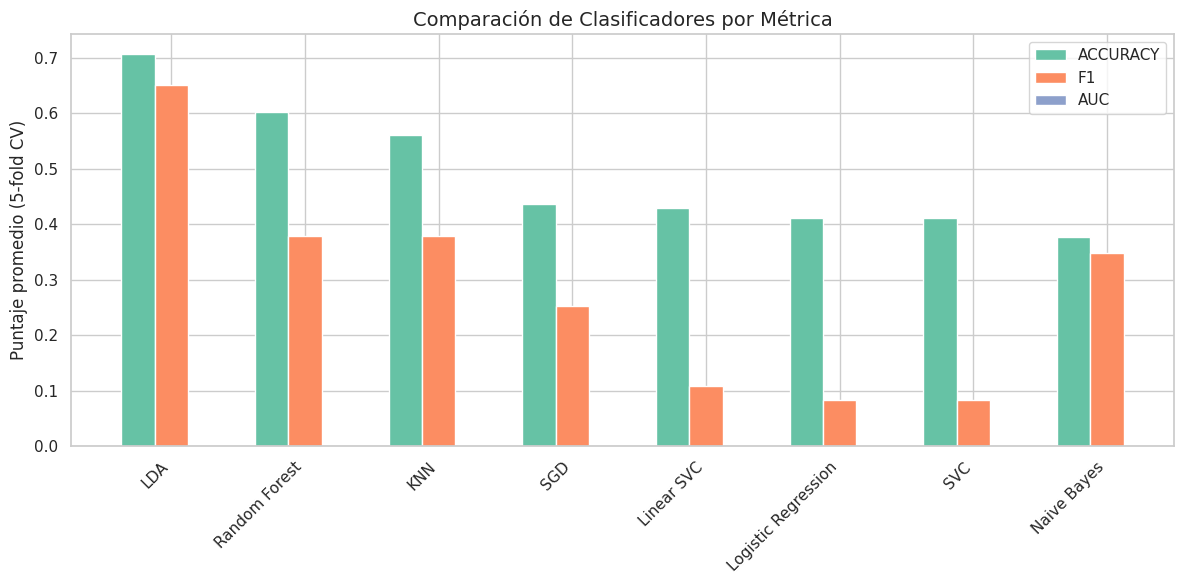

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuramos estilo gráfico
sns.set(style="whitegrid", palette="Set2")

# Definimos las métricas a graficar
# Changed 'roc_auc' to 'AUC' to match the DataFrame column name
metricas = ['accuracy', 'f1', 'AUC']

# Creamos figura y ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Ancho de barra por métrica
bar_width = 0.25
x = np.arange(len(df_resultados['Modelo']))

# Graficamos cada métrica con un desplazamiento en el eje x
for i, metrica in enumerate(metricas):
    ax.bar(x + i * bar_width,
           df_resultados[metrica],
           width=bar_width,
           label=metrica.upper())

# Etiquetas y leyenda
ax.set_title("Comparación de Clasificadores por Métrica", fontsize=14)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(df_resultados['Modelo'], rotation=45, ha='right')
ax.set_ylabel("Puntaje promedio (5-fold CV)")
ax.legend()
plt.tight_layout()
plt.show()


# Análisis de Comparación de Clasificadores

## Interpretación del Gráfico

Este gráfico compara el rendimiento de 8 algoritmos de clasificación usando tres métricas clave:
- **Accuracy** (verde): Porcentaje de predicciones correctas
- **F1** (naranja): Balance entre precisión y recall
- **AUC** (azul): Área bajo la curva ROC

## Resultados por Clasificador

### **Mejores Performers:**
1. **LDA (Linear Discriminant Analysis)**: Líder absoluto con ~70% accuracy y ~65% F1
2. **Random Forest**: Segundo lugar con ~59% accuracy y ~39% F1
3. **KNN**: Tercero con ~56% accuracy y ~38% F1

### **Rendimiento Medio:**
- **SGD, Linear SVC, Logistic Regression, SVC**: Accuracy entre 40-45%
- **Naive Bayes**: El más bajo con ~38% accuracy

## Observaciones Clave

**Patrón Notable:** Existe una gran diferencia entre las métricas Accuracy y F1 en varios clasificadores (especialmente SGD, Linear SVC, SVC), lo que sugiere:
- Posible **desbalance de clases** en el dataset
- Algunos algoritmos predicen principalmente la clase mayoritaria
- F1 score penaliza este comportamiento mostrando el rendimiento real


## Conclusión

**LDA es claramente el mejor clasificador** para este dataset específico, seguido por Random Forest. La gran diferencia entre Accuracy y F1 en otros modelos indica que el problema tiene clases desbalanceadas, por lo que el F1 score es más confiable para evaluar el rendimiento real.